## Import Modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization
import dataretrieval.nwis as nwis
import datetime as dt
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Input Variables

#### Expected important variables for forecasting streamflow

1. max swe (single value) - how much water did we recieve as snow
2. swe & delta swe (daily) - much much water is there as snow and how is it melting per time step
3. temperature (daily) - how warm/cool is it. Captures melting snow and ET.
4. precipitation - rainfall runoff response
5. ET (daily & cumulative) - how much water is leaving the system
6. carryover (single value) - how much water was left in the system. this impacts management. 


In [2]:
## Input year ranges
startYear = 2000
endYear = 2024
splitYear = 2018

## Set time range of data ##
startDate = str(startYear)+'-01-01' 
endDate = str(endYear)+'-04-01'

## Set split date as a datetime variable ##
train_test_split_date = pd.to_datetime(dt.datetime.strptime(str(splitYear)+'-01-01', '%Y-%m-%d').date())

## USGS Streamflow Site - This is our target timeseries ## 
USGS_site_id = '13247500' # Payette nr Horseshoe Bend - USGS ID = 13247500

In [3]:
## Record relevant snotel sites & their elevation ## 
snotel_sites = [['Banner_Summit', 312, 7040], ['Bear_Basin', 319, 5350], ['Big_Creek_Summit', 338, 6560], ['Bogus_Basin', 978, 6340], ['Brundage_Reservoir', 370, 6250],
                ['Cozy_Cove', 423, 5400], ['Deadwood_Summit', 439, 6860], ['Jackson_Peak', 550, 7070], ['Long_Valley', 1016, 4890], ['Secesh_Summit', 740, 6540],
                ['Puhi_Flat', 782, 6240], ['Van_Wyck', 979, 4920]]

snotel_sites= pd.DataFrame(snotel_sites, columns = ['Name', 'ID', 'Elevation_ft'])

## Historical Streamflow Data

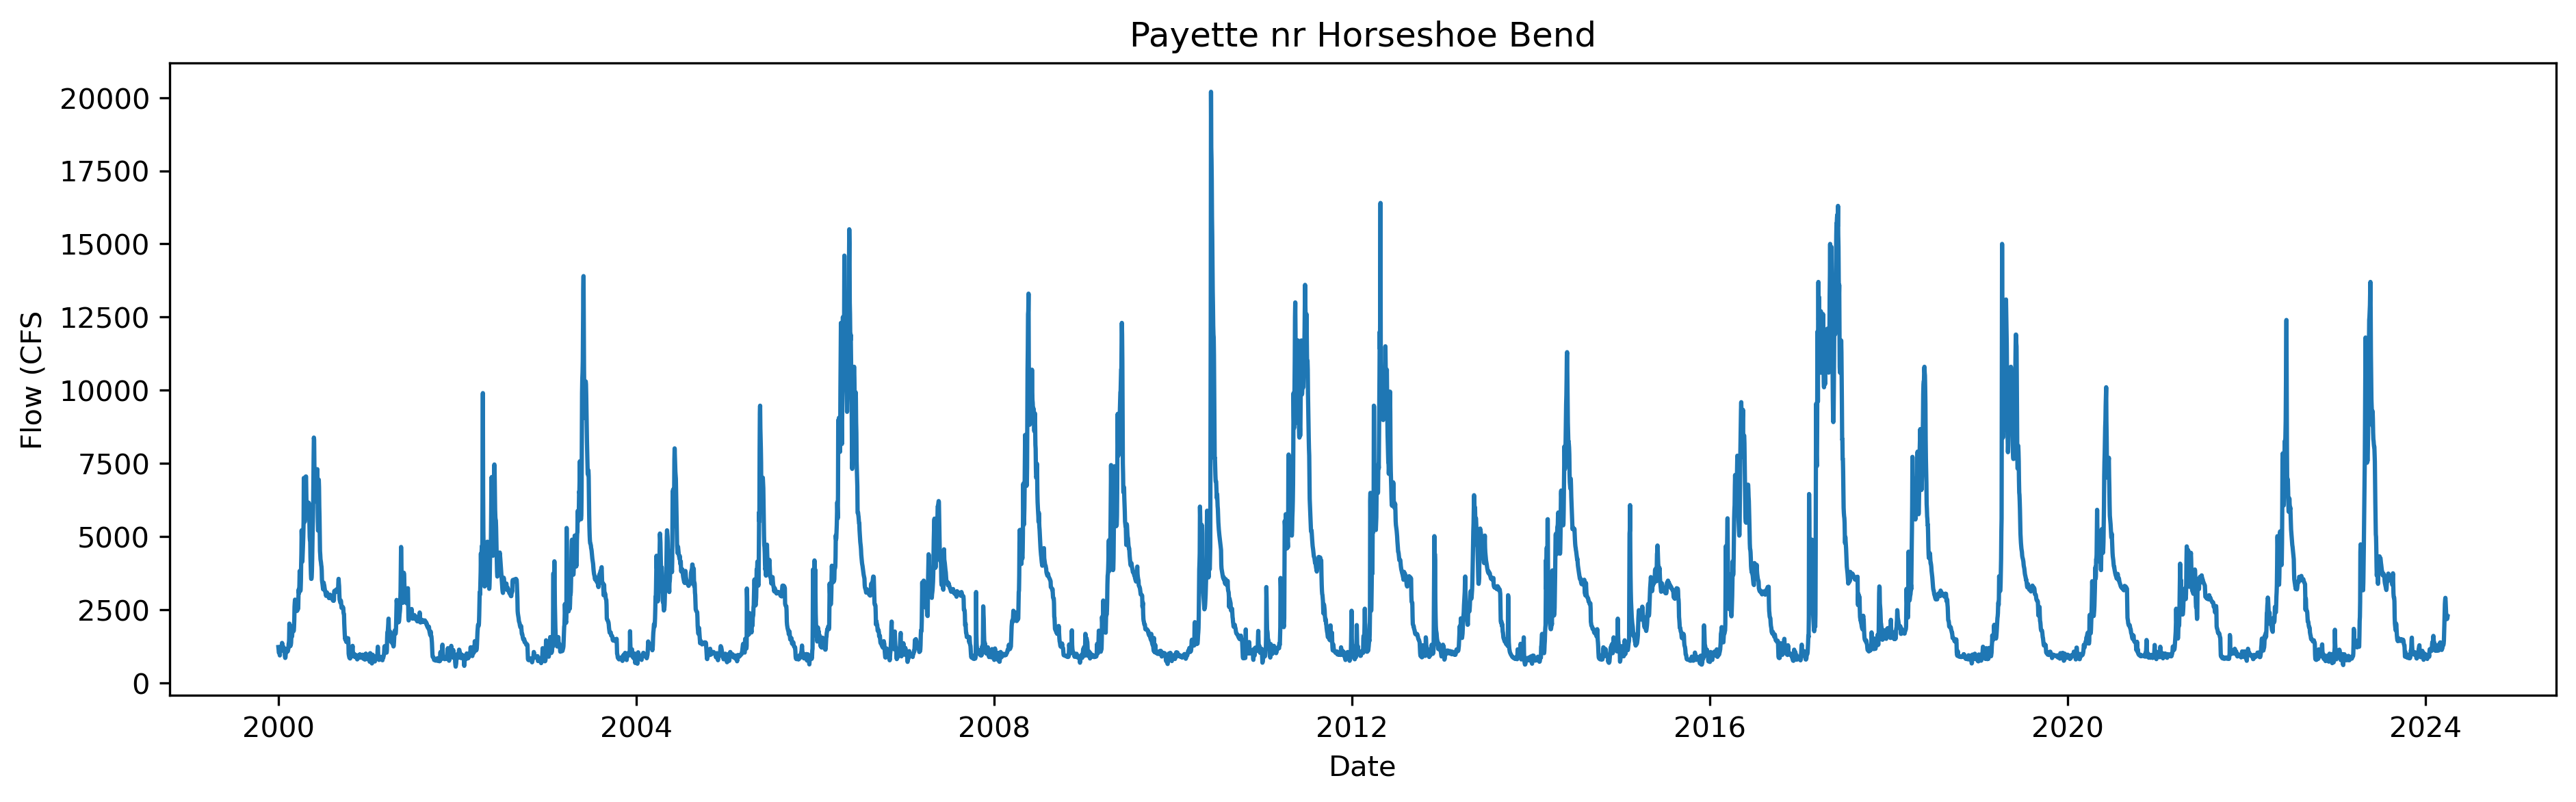

In [4]:
## Get USGS data ##
flow = nwis.get_record(sites = USGS_site_id, service = 'dv', parameterCd = '00060', start = startDate, end = endDate) #import
flow = flow.drop(columns=['00060_Mean_cd','site_no']) #drop unnecessary columns
flow = flow.rename(columns={"00060_Mean": 'flow_cfs'}) #rename daily mean flow column
flow.index.names = ['Date'] # rename index
flow.index = flow.index.date # convert to datetime to just date
flow.index = pd.to_datetime(flow.index) # set at pd.datetime

## Plot streamflow timeseries ##
plt.figure(figsize=(15,4), dpi=300)
plt.plot(flow.index, flow['flow_cfs'], color='tab:blue')
plt.gca().set(title='Payette nr Horseshoe Bend', xlabel='Date', ylabel='Flow (CFS')
plt.show()

## Features/Predictor Variables Creation

In [5]:
## Pull Hydromet Reservoir data ##

## Lake Cascade ## 
url = 'https://www.usbr.gov/pn-bin/daily.pl?station=csc&format=html&year='+str(startYear)+'&month=1&day=1&year='+str(endYear)+'&month=1&day=1&pcode=af'
cascade = pd.read_html(url, parse_dates = ['DateTime'], index_col = 'DateTime', skiprows = 0)
cascade = pd.DataFrame(cascade[0])

## Deadwood Reservoir ##
url = 'https://www.usbr.gov/pn-bin/daily.pl?station=ded&format=html&year='+str(startYear)+'&month=1&day=1&year='+str(endYear)+'&month=1&day=1&pcode=af'
deadwood = pd.read_html(url, parse_dates = ['DateTime'], index_col = 'DateTime',skiprows = 0)
deadwood = pd.DataFrame(deadwood[0])

## Total Reservoir ##
reservoir = pd.concat([cascade, deadwood], axis = 1) # combine reservoir data into one dataframe
reservoir['reservoir_af'] = reservoir['csc_af']+reservoir['ded_af']
reservoir = reservoir.drop(columns = ['csc_af','ded_af'])
reservoir['dayofyear'] = reservoir.index.dayofyear
reservoir['year'] = reservoir.index.year
reservoir['water_year'] = reservoir.index.year.where(reservoir.index.month < 10, reservoir.index.year + 1)       

,reservoir_af,dayofyear,year,water_year
DateTime,,,,
2000-01-01,549180.13,1,2000,2000
2000-01-02,550101.79,2,2000,2000
2000-01-03,550332.26,3,2000,2000
2000-01-04,552742.52,4,2000,2000
2000-01-05,553030.17,5,2000,2000
...,...,...,...,...
2023-12-28,510106.00,362,2023,2024
2023-12-29,510337.00,363,2023,2024
2023-12-30,510781.00,364,2023,2024


In [6]:
## Calculate reservoir carryover (storage on November 1st) and set carryover for each water year ## 
carryover = reservoir.loc[reservoir['dayofyear'] == 305]
for i in range(len(carryover['reservoir_af'])):
    if i > 0:
        reservoir.loc[reservoir['water_year'] == carryover['water_year'][i], 'carryover_af'] = carryover['reservoir_af'][i]

,reservoir_af,dayofyear,year,water_year,carryover_af
DateTime,,,,,
2000-01-01,549180.13,1,2000,2000,NaN
2000-01-02,550101.79,2,2000,2000,NaN
2000-01-03,550332.26,3,2000,2000,NaN
2000-01-04,552742.52,4,2000,2000,NaN
2000-01-05,553030.17,5,2000,2000,NaN
...,...,...,...,...,...
2023-12-28,510106.00,362,2023,2024,477768.0
2023-12-29,510337.00,363,2023,2024,477768.0
2023-12-30,510781.00,364,2023,2024,477768.0


,reservoir_af,dayofyear,year,water_year
DateTime,,,,
2000-10-31,444693.68,305,2000,2001
2001-11-01,307950.25,305,2001,2002
2002-11-01,413951.74,305,2002,2003
2003-11-01,426989.27,305,2003,2004
2004-10-31,472479.24,305,2004,2005
2005-11-01,432532.74,305,2005,2006
2006-11-01,473154.88,305,2006,2007
2007-11-01,412789.00,305,2007,2008
2008-10-31,461863.00,305,2008,2009


In [7]:
## Load SNOTEL Sites ##
snotel = pd.DataFrame()
for i in range(len(snotel_sites['ID'])):
    url = 'https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/'+str(snotel_sites['ID'][i])+':ID:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/WTEQ::value,PREC::value,TAVG::value?fitToScreen=false'
    site_snotel = pd.read_csv(url, parse_dates = ['Date'], skiprows = 60)
    site_snotel.rename(columns={site_snotel.columns[1]: 'SWE_in'}, inplace=True) # rename columns
    site_snotel.rename(columns={site_snotel.columns[2]: 'Precip_in'}, inplace=True)
    site_snotel.rename(columns={site_snotel.columns[3]: 'Temp_degF'}, inplace=True)
    #site_snotel['site_id'] = snotel_sites['ID'][i]
    site_snotel['site_elevation_ft'] = snotel_sites['Elevation_ft'][i]
    snotel = pd.concat([snotel, site_snotel], axis=0)

snotel = snotel[snotel['Date'] >= startDate] # Crop data to start date
snotel = snotel[snotel['Date'] <= endDate] # and end date

In [8]:
## Split Snotel by high and low elevation ##
snotel_high_elev = snotel.loc[snotel['site_elevation_ft'] > 6000] 
snotel_low_elev = snotel.loc[snotel['site_elevation_ft'] <= 6000] 

## Get Average SWE and Air Temperature Between All Sites ##
snotel_avg = snotel.groupby(['Date']).mean()
snotel_avg.index = pd.to_datetime(snotel_avg.index)

snotel_avg_high = snotel_high_elev.groupby(['Date']).mean()
snotel_avg_high.index = pd.to_datetime(snotel_avg.index)
snotel_avg_high.rename(columns={'SWE_in': 'high_elev_SWE_in','Precip_in': 'high_elev_Precip_in', 'Temp_degF': 'high_elev_Temp_degF'}, inplace=True) 

snotel_avg_low = snotel_low_elev.groupby(['Date']).mean()
snotel_avg_low.index = pd.to_datetime(snotel_avg.index)
snotel_avg_low.rename(columns={'SWE_in': 'low_elev_SWE_in','Precip_in': 'low_elev_Precip_in', 'Temp_degF': 'low_elev_Temp_degF'}, inplace=True) 

#display(snotel_avg)

In [9]:
## Import ET data ##
et = pd.read_csv('data/Payette_ET.csv', index_col = 'date')
et.index = pd.to_datetime(et.index)
et

,mean_et_kg/m^2/day,mean_pet_kg/m^2/day
date,,
2000-01-01,5.179853,35.180300
2000-01-09,6.010455,36.527710
2000-01-17,6.960786,38.479866
2000-01-25,7.600873,39.130070
2000-02-02,10.539650,47.083730
...,...,...
2023-11-25,5.283309,37.558754
2023-12-03,6.031435,37.337590
2023-12-11,6.086441,37.202890


## Combine features and target variables

In [10]:
## Combine Prediction Variable and Feature Variable Dataframes
data = pd.concat([flow, et, reservoir, snotel_avg, snotel_avg_high, snotel_avg_low],axis=1, join = 'outer')
data['mean_et_kg/m^2/day'] = data['mean_et_kg/m^2/day'].interpolate(method='linear') # interpolate between missing ET data 
data['mean_pet_kg/m^2/day'] = data['mean_pet_kg/m^2/day'].interpolate(method='linear') # interpolate between missing PET data 
pd.to_datetime(data.index)
display(data)

,flow_cfs,mean_et_kg/m^2/day,mean_pet_kg/m^2/day,reservoir_af,dayofyear,year,water_year,carryover_af,SWE_in,Precip_in,Temp_degF,site_elevation_ft,high_elev_SWE_in,high_elev_Precip_in,high_elev_Temp_degF,site_elevation_ft,low_elev_SWE_in,low_elev_Precip_in,low_elev_Temp_degF,site_elevation_ft
2000-01-01,1220.0,5.179853,35.180300,549180.13,1.0,2000.0,2000.0,NaN,8.700000,13.290000,20.920000,6365.000000,9.5625,14.2625,20.6000,6612.5,5.250,9.400,22.200,5375.0
2000-01-02,1140.0,5.283679,35.348726,550101.79,2.0,2000.0,2000.0,NaN,8.820000,13.380000,15.390000,6365.000000,9.7000,14.3625,14.8750,6612.5,5.300,9.450,17.450,5375.0
2000-01-03,1030.0,5.387504,35.517153,550332.26,3.0,2000.0,2000.0,NaN,8.980000,13.510000,10.970000,6365.000000,9.8750,14.5000,11.5375,6612.5,5.400,9.550,8.700,5375.0
2000-01-04,1020.0,5.491329,35.685579,552742.52,4.0,2000.0,2000.0,NaN,9.190000,13.710000,23.310000,6365.000000,10.1000,14.7125,23.3625,6612.5,5.550,9.700,23.100,5375.0
2000-01-05,1020.0,5.595154,35.854005,553030.17,5.0,2000.0,2000.0,NaN,10.250000,14.690000,17.640000,6365.000000,11.2000,15.7125,17.1875,6612.5,6.450,10.600,19.450,5375.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28,2320.0,4.739605,35.287820,NaN,NaN,NaN,NaN,NaN,18.741667,23.983333,30.358333,6121.666667,24.0000,27.5000,29.2125,6612.5,8.225,16.950,32.650,5140.0
2024-03-29,2290.0,4.739605,35.287820,NaN,NaN,NaN,NaN,NaN,19.350000,24.625000,31.308333,6121.666667,24.7375,28.2000,29.7250,6612.5,8.575,17.475,34.475,5140.0
2024-03-30,2180.0,4.739605,35.287820,NaN,NaN,NaN,NaN,NaN,19.366667,24.666667,33.275000,6121.666667,24.7875,28.2500,31.9750,6612.5,8.525,17.500,35.875,5140.0
2024-03-31,2210.0,4.739605,35.287820,NaN,NaN,NaN,NaN,NaN,19.308333,24.683333,32.866667,6121.666667,24.8000,28.2625,31.5000,6612.5,8.325,17.525,35.600,5140.0


In [11]:
## Add Time Features ##
data['year'] = data.index.year
data['dayofyear'] = data.index.dayofyear
data['weekofyear'] = data.index.isocalendar().week
data

,flow_cfs,mean_et_kg/m^2/day,mean_pet_kg/m^2/day,reservoir_af,dayofyear,year,water_year,carryover_af,SWE_in,Precip_in,...,site_elevation_ft,high_elev_SWE_in,high_elev_Precip_in,high_elev_Temp_degF,site_elevation_ft,low_elev_SWE_in,low_elev_Precip_in,low_elev_Temp_degF,site_elevation_ft,weekofyear
2000-01-01,1220.0,5.179853,35.180300,549180.13,1,2000,2000.0,NaN,8.700000,13.290000,...,6365.000000,9.5625,14.2625,20.6000,6612.5,5.250,9.400,22.200,5375.0,52
2000-01-02,1140.0,5.283679,35.348726,550101.79,2,2000,2000.0,NaN,8.820000,13.380000,...,6365.000000,9.7000,14.3625,14.8750,6612.5,5.300,9.450,17.450,5375.0,52
2000-01-03,1030.0,5.387504,35.517153,550332.26,3,2000,2000.0,NaN,8.980000,13.510000,...,6365.000000,9.8750,14.5000,11.5375,6612.5,5.400,9.550,8.700,5375.0,1
2000-01-04,1020.0,5.491329,35.685579,552742.52,4,2000,2000.0,NaN,9.190000,13.710000,...,6365.000000,10.1000,14.7125,23.3625,6612.5,5.550,9.700,23.100,5375.0,1
2000-01-05,1020.0,5.595154,35.854005,553030.17,5,2000,2000.0,NaN,10.250000,14.690000,...,6365.000000,11.2000,15.7125,17.1875,6612.5,6.450,10.600,19.450,5375.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28,2320.0,4.739605,35.287820,NaN,88,2024,NaN,NaN,18.741667,23.983333,...,6121.666667,24.0000,27.5000,29.2125,6612.5,8.225,16.950,32.650,5140.0,13
2024-03-29,2290.0,4.739605,35.287820,NaN,89,2024,NaN,NaN,19.350000,24.625000,...,6121.666667,24.7375,28.2000,29.7250,6612.5,8.575,17.475,34.475,5140.0,13
2024-03-30,2180.0,4.739605,35.287820,NaN,90,2024,NaN,NaN,19.366667,24.666667,...,6121.666667,24.7875,28.2500,31.9750,6612.5,8.525,17.500,35.875,5140.0,13
2024-03-31,2210.0,4.739605,35.287820,NaN,91,2024,NaN,NaN,19.308333,24.683333,...,6121.666667,24.8000,28.2625,31.5000,6612.5,8.325,17.525,35.600,5140.0,13


In [12]:
## calculate peak SWE for each year ## 
data['prev_year_peak_SWE_in'] = np.nan # initialize
peak_swe = data.groupby(['year'])['SWE_in'].max()
peak_swe = pd.DataFrame(peak_swe)
peak_swe = peak_swe.reset_index()

## Get max SWE for current year
for i in range(len(peak_swe.index)):
    if i > 0:
        data.loc[data['year'] == peak_swe['year'][i], 'peak_SWE_in'] = peak_swe['SWE_in'][i]

## Get max SWE for previous year 
for i in range(len(peak_swe.index)-1):
    if i > 0:
        data.loc[data['year'] == peak_swe['year'][i], 'prev_year_peak_SWE_in'] = peak_swe['SWE_in'][i-1]

## Convert to Weekly Data

In [13]:
## drop any rows with nan
data = data.dropna(axis = 0)
data_weekly = data.resample('1W').mean()

#data_weekly = data.groupby(['year', 'weekofyear']).mean()
data_weekly['delta_SWE_in'] = data_weekly['SWE_in'].diff(1)
data_weekly['delta_Precip_in'] = data_weekly['Precip_in'].diff(1)
data_weekly['delta_Temp_degF'] = data_weekly['Temp_degF'].diff(1)

data_weekly['high_elev_delta_SWE_in'] = data_weekly['high_elev_SWE_in'].diff(1)
data_weekly['high_elev_delta_Precip_in'] = data_weekly['high_elev_Precip_in'].diff(1)
data_weekly['high_elev_delta_Temp_degF'] = data_weekly['high_elev_Temp_degF'].diff(1)

data_weekly['low_elev_delta_SWE_in'] = data_weekly['low_elev_SWE_in'].diff(1)
data_weekly['low_elev_delta_Precip_in'] = data_weekly['low_elev_Precip_in'].diff(1)
data_weekly['low_elev_delta_Temp_degF'] = data_weekly['low_elev_Temp_degF'].diff(1)

data_weekly

,flow_cfs,mean_et_kg/m^2/day,mean_pet_kg/m^2/day,reservoir_af,dayofyear,year,water_year,carryover_af,SWE_in,Precip_in,...,peak_SWE_in,delta_SWE_in,delta_Precip_in,delta_Temp_degF,high_elev_delta_SWE_in,high_elev_delta_Precip_in,high_elev_delta_Temp_degF,low_elev_delta_SWE_in,low_elev_delta_Precip_in,low_elev_delta_Temp_degF
2001-10-07,761.857143,3.811961,66.752933,303178.944286,277.0,2001.0,2002.0,307950.25,0.000000,0.000000,...,14.340000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-10-14,778.857143,4.243970,57.900114,301450.681429,284.0,2001.0,2002.0,307950.25,0.196429,0.417857,...,14.340000,0.196429,0.417857,-12.762338,0.289286,0.476786,-13.241071,0.010714,0.300000,-11.485714
2001-10-21,745.571429,3.794533,57.147134,302257.504286,291.0,2001.0,2002.0,307950.25,0.201190,1.191667,...,14.340000,0.004762,0.773810,4.468831,0.012500,0.919643,4.851786,-0.010714,0.482143,3.447619
2001-10-28,864.000000,4.374031,52.566136,303297.324286,298.0,2001.0,2002.0,307950.25,0.234524,1.936905,...,14.340000,0.033333,0.745238,-3.480519,0.050000,0.873214,-3.546429,0.000000,0.489286,-3.304762
2001-11-04,1046.571429,4.075852,52.725327,307231.702857,305.0,2001.0,2002.0,307950.25,0.117857,3.626190,...,14.340000,-0.116667,1.689286,2.918182,-0.175000,1.960714,2.821429,0.000000,1.146429,3.176190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03,905.857143,5.750888,37.420527,494862.285714,334.0,2023.0,2024.0,477768.00,1.233333,5.329762,...,28.416667,0.402381,0.304762,-1.166342,0.507143,0.348214,-0.410204,0.192857,0.217857,-2.600000
2023-12-10,1145.714286,6.058938,37.270240,501071.000000,341.0,2023.0,2024.0,477768.00,3.515476,7.383333,...,28.416667,2.282143,2.053571,4.586905,2.925000,2.364286,3.755357,0.996429,1.432143,6.250000
2023-12-17,965.142857,6.283961,37.645192,505263.285714,348.0,2023.0,2024.0,477768.00,4.313095,8.316667,...,28.416667,0.797619,0.933333,-4.746429,0.978571,1.050000,-3.537500,0.435714,0.700000,-7.164286
2023-12-24,998.857143,6.101911,37.532405,507854.857143,355.0,2023.0,2024.0,477768.00,4.534524,8.621429,...,28.416667,0.221429,0.304762,2.800000,0.264286,0.341071,2.437500,0.135714,0.232143,3.525000


In [14]:
data_weekly = data_weekly.drop(columns=['site_elevation_ft', 'year'])
data_weekly.index.names = ['Date'] 
data_weekly.to_csv('outputs/streamflow_forecast_data.csv', index=True)  

In [15]:
data_weekly.columns.tolist()

['flow_cfs',
 'mean_et_kg/m^2/day',
 'mean_pet_kg/m^2/day',
 'reservoir_af',
 'dayofyear',
 'water_year',
 'carryover_af',
 'SWE_in',
 'Precip_in',
 'Temp_degF',
 'high_elev_SWE_in',
 'high_elev_Precip_in',
 'high_elev_Temp_degF',
 'low_elev_SWE_in',
 'low_elev_Precip_in',
 'low_elev_Temp_degF',
 'weekofyear',
 'prev_year_peak_SWE_in',
 'peak_SWE_in',
 'delta_SWE_in',
 'delta_Precip_in',
 'delta_Temp_degF',
 'high_elev_delta_SWE_in',
 'high_elev_delta_Precip_in',
 'high_elev_delta_Temp_degF',
 'low_elev_delta_SWE_in',
 'low_elev_delta_Precip_in',
 'low_elev_delta_Temp_degF']